In [1]:
import pandas as pd
import numpy as np
import pdcast as pdc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC


from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [3]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [4]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [5]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [6]:
df_train = pdc.downcast(df_train)

In [7]:
df_train = df_train.drop(['Soil_Type7','Soil_Type15'],axis=1)

In [8]:
print(df_train[['Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology']].isnull().sum())

Horizontal_Distance_To_Hydrology    0
Vertical_Distance_To_Hydrology      0
dtype: int64


In [9]:
df_train.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
       'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40',
       'Cover_Type'],
      dtype

In [10]:
# class FeatureEngineer:
#     def __init__(self, data):
#         self.data = data

#     def calculate_distances(self):
#         # Расчет расстояния до ближайшего водоема
#         self.data['Distance_To_Hydrology'] = np.sqrt(
#             (self.data.Horizontal_Distance_To_Hydrology ^ 2) + 
#             (self.data.Vertical_Distance_To_Hydrology ^ 2)
#         )

#         # Расчет расстояния до ближайших огненных точек
#         self.data['Distance_To_Fire_Points'] = (
#             self.data.Horizontal_Distance_To_Fire_Points - 
#             self.data.Horizontal_Distance_To_Roadways
#         )

#     def normalize_elevation(self):
#         # Нормализация высоты
#         self.data['normalized_elevation'] = (self.data['Elevation'] - self.data['Elevation'].min()) / (self.data['Elevation'].max() - self.data['Elevation'].min())

#     def create_interaction_features(self):
#         # Сложные взаимодействия
#         self.data['elevation_slope'] = self.data['Elevation'] * self.data['Slope']

#     # def categorize_elevation(self):
#     #     # Категоризация высоты
#     #     self.data['elevation_category'] = pd.cut(self.data['Elevation'], bins=[0, 2000, 3000, 4000], labels=['low', 'medium', 'high'])



#     def engineer_features(self):
#         """Выполнить все шаги создания признаков."""
#         self.calculate_distances()
#         self.normalize_elevation()
#         self.create_interaction_features()
#         # self.categorize_elevation()
        

#         return self.data

# feature_engineer = FeatureEngineer(df_train)
# df_train = feature_engineer.engineer_features()

In [11]:
df_train['Distance_To_Hydrology'] = np.sqrt((df_train.Horizontal_Distance_To_Hydrology ^ 2) + (df_train.Vertical_Distance_To_Hydrology ^ 2))
df_train['Distance_To_Fire_Points'] = df_train.Horizontal_Distance_To_Fire_Points - df_train. Horizontal_Distance_To_Roadways

df_test['Distance_To_Hydrology'] = np.sqrt((df_test.Horizontal_Distance_To_Hydrology ^ 2) + (df_test.Vertical_Distance_To_Hydrology ^ 2))
df_test['Distance_To_Fire_Points'] = df_test.Horizontal_Distance_To_Fire_Points - df_test. Horizontal_Distance_To_Roadways

In [12]:
TARGET_NAME = 'Cover_Type'
NEW_FEATURE_NAMES = ['Distance_To_Hydrology', 'Distance_To_Fire_Points']
BASE_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + NEW_FEATURE_NAMES ).tolist()

In [13]:
NUM_FEATURE_NAMES = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points'] + NEW_FEATURE_NAMES

CAT_FEATURE_NAMES = ['Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
       'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']

In [14]:
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES 

## EDA

In [15]:
df_train['Cover_Type'].value_counts(normalize=True)

Cover_Type
2    0.576776
1    0.202634
5    0.048204
7    0.043097
3    0.043097
6    0.043097
4    0.043097
Name: proportion, dtype: float64

In [16]:
numerical_features = df_train.select_dtypes(include=[np.number]).drop('Cover_Type',axis=1)
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

count of numeric_features 12


Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Distance_To_Hydrology',
       'Distance_To_Fire_Points'],
      dtype='object')

In [17]:
# df_train = pdc.downcast(df_train)

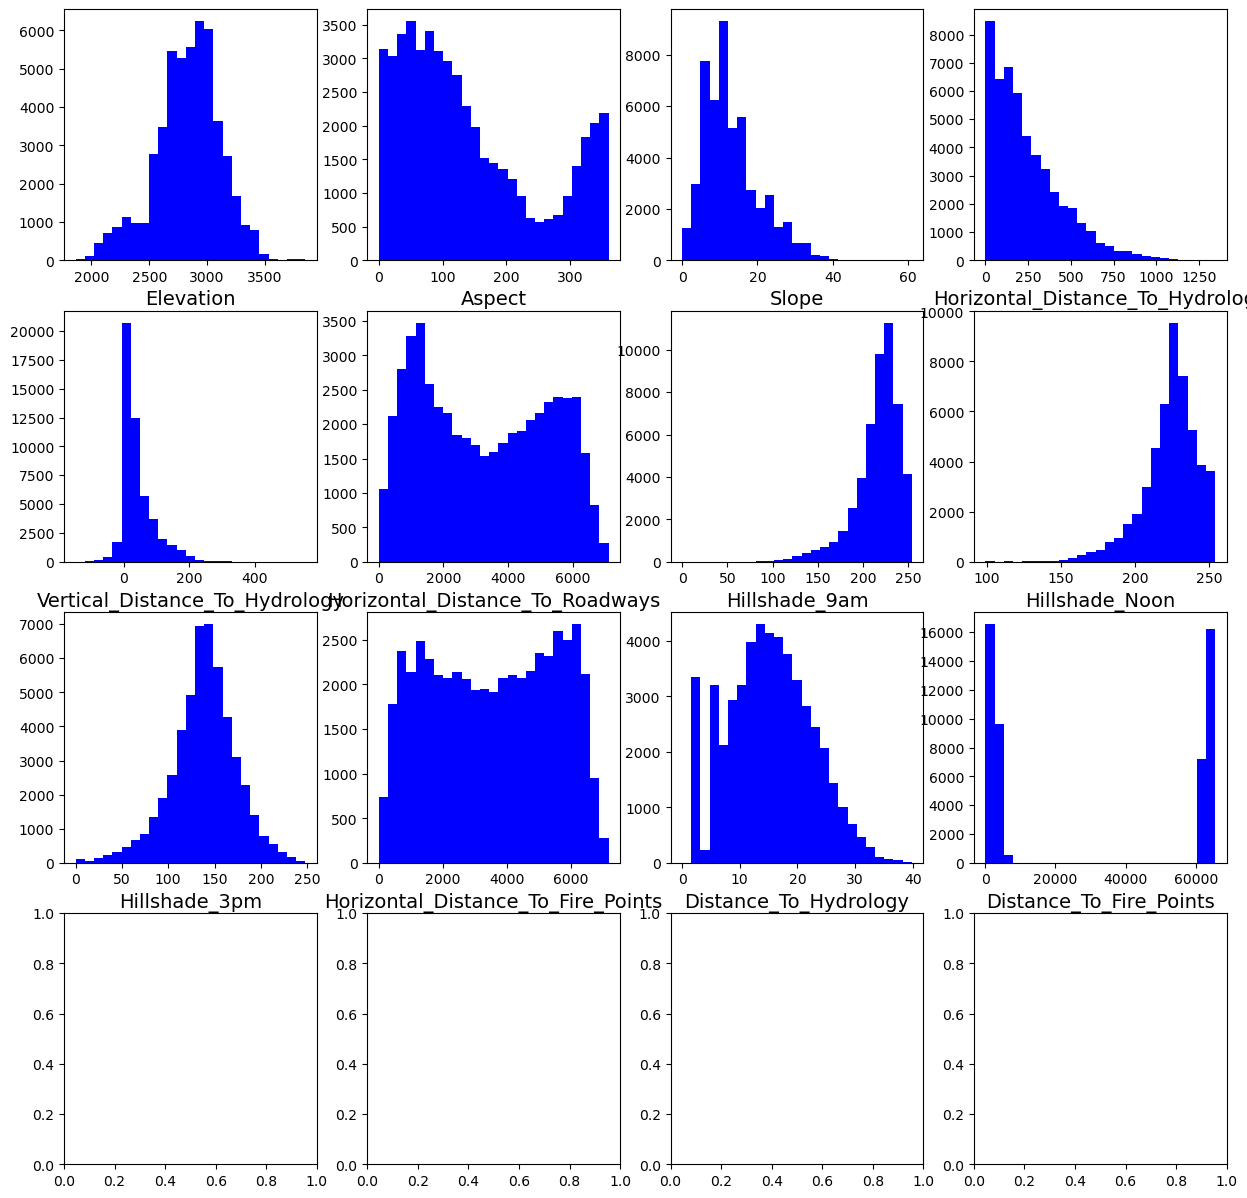

In [18]:
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

for num, feature in enumerate(numerical_features):
    data = df_train[feature].copy()
    axes[num//4, num%4].hist(data, bins=25, color="blue")
    axes[num//4, num%4].set_xlabel(feature, fontsize=14)

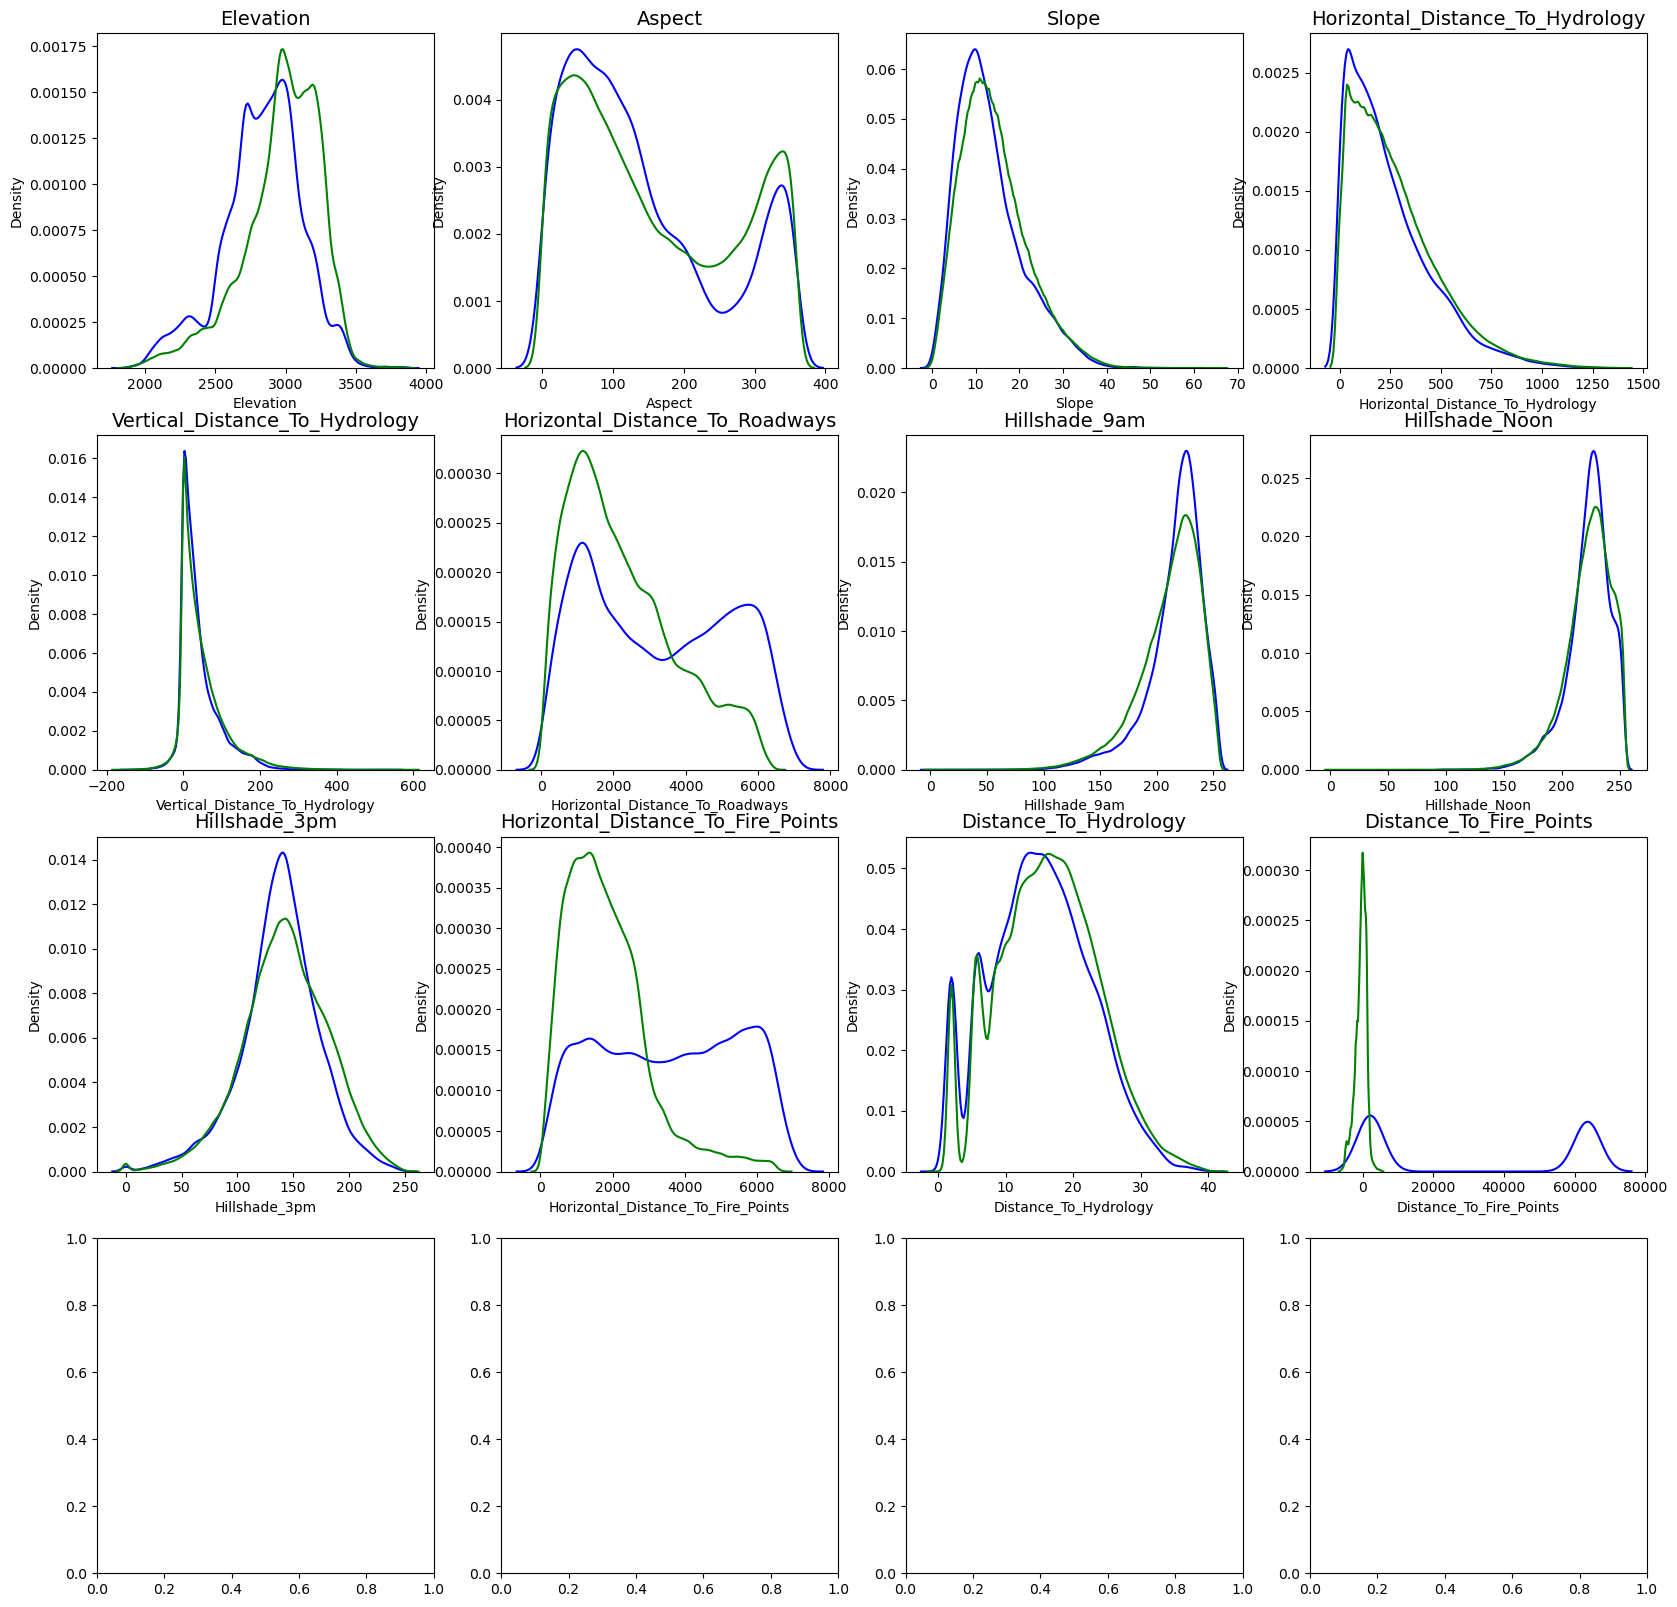

In [19]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for num, feature in enumerate(numerical_features):
    try:
        train_data, test_data = df_train[feature].copy(), df_test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//4, num%4], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = df_train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
    axes[num//4, num%4].set_title(feature, fontsize=14)

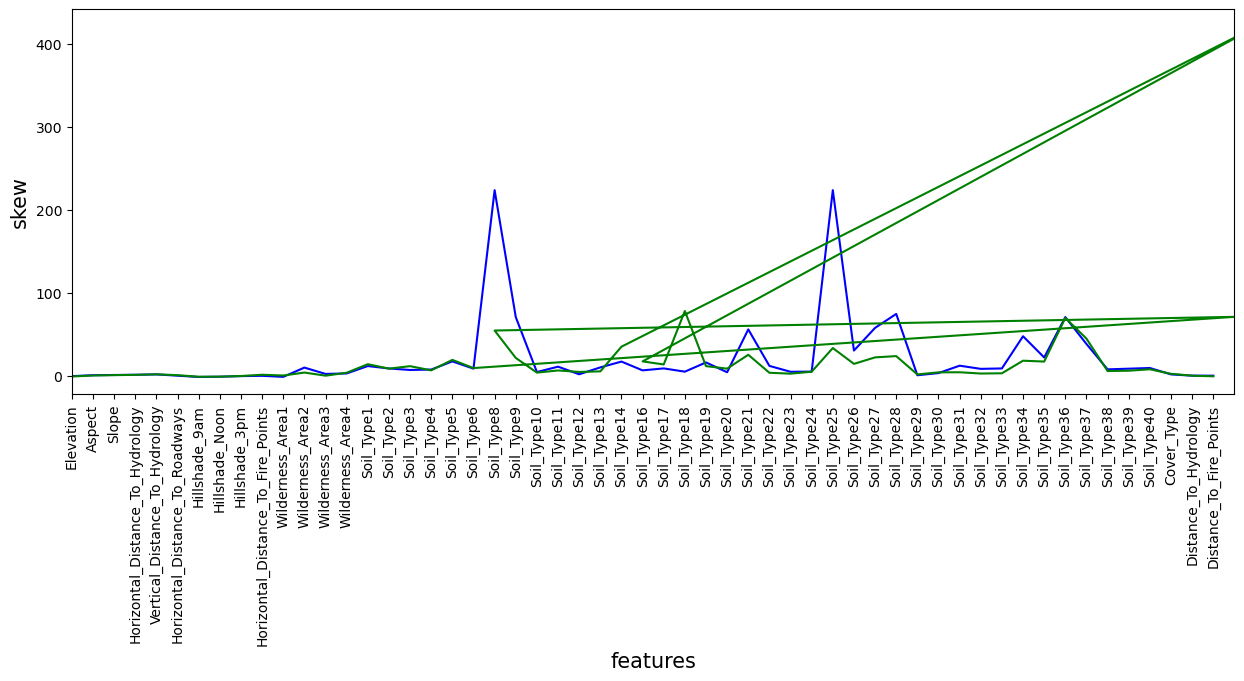

In [20]:
fig = plt.figure(figsize=(15, 5))
train_stats, test_stats = df_train.skew(), df_test.skew()
plt.plot(train_stats, color="blue", label="train")
plt.plot(test_stats, color="green", label="test")
plt.xticks(range(train_stats.shape[0]), train_stats.index, rotation=90)
plt.xlabel("features", size=15)
plt.xlim(0, len(train_stats))
plt.ylabel("skew", size=15)
plt.show()

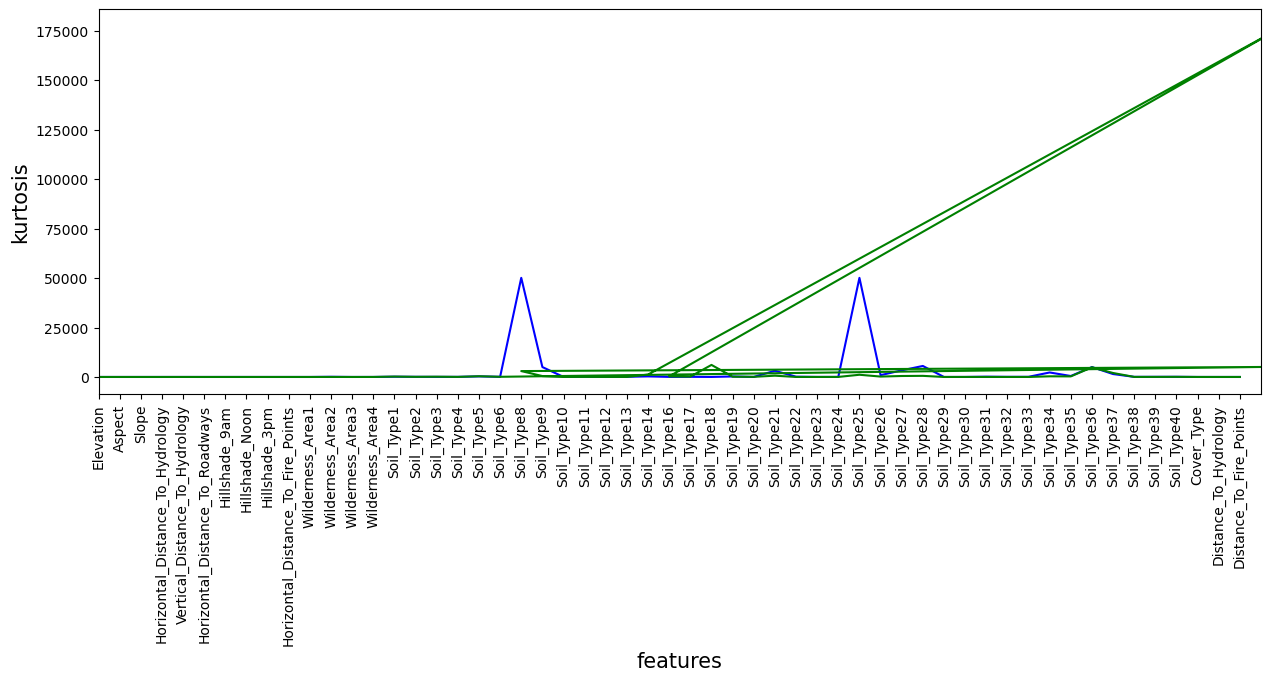

In [21]:
fig = plt.figure(figsize=(15, 5))
train_stats, test_stats = df_train.kurtosis(), df_test.kurtosis()
plt.plot(train_stats, color="blue", label="train")
plt.plot(test_stats, color="green", label="test")
plt.xticks(range(train_stats.shape[0]), train_stats.index, rotation=90)
plt.xlabel("features", size=15)
plt.ylabel("kurtosis", size=15)
plt.xlim(0, len(train_stats))
plt.show()

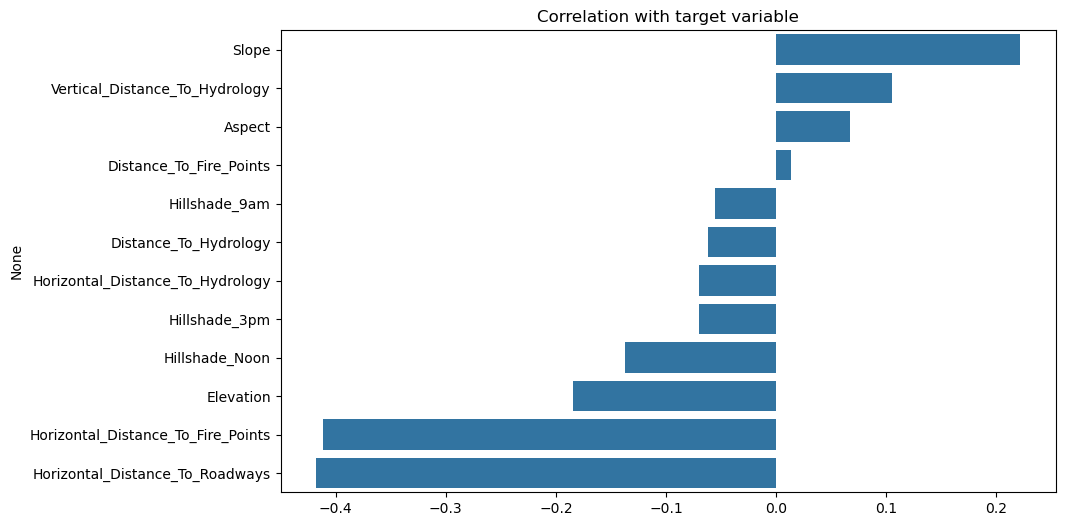

In [22]:
TARGET_NAME = 'Cover_Type'
BASE_FEATURE_NAMES = numerical_features.columns.tolist()
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 6))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

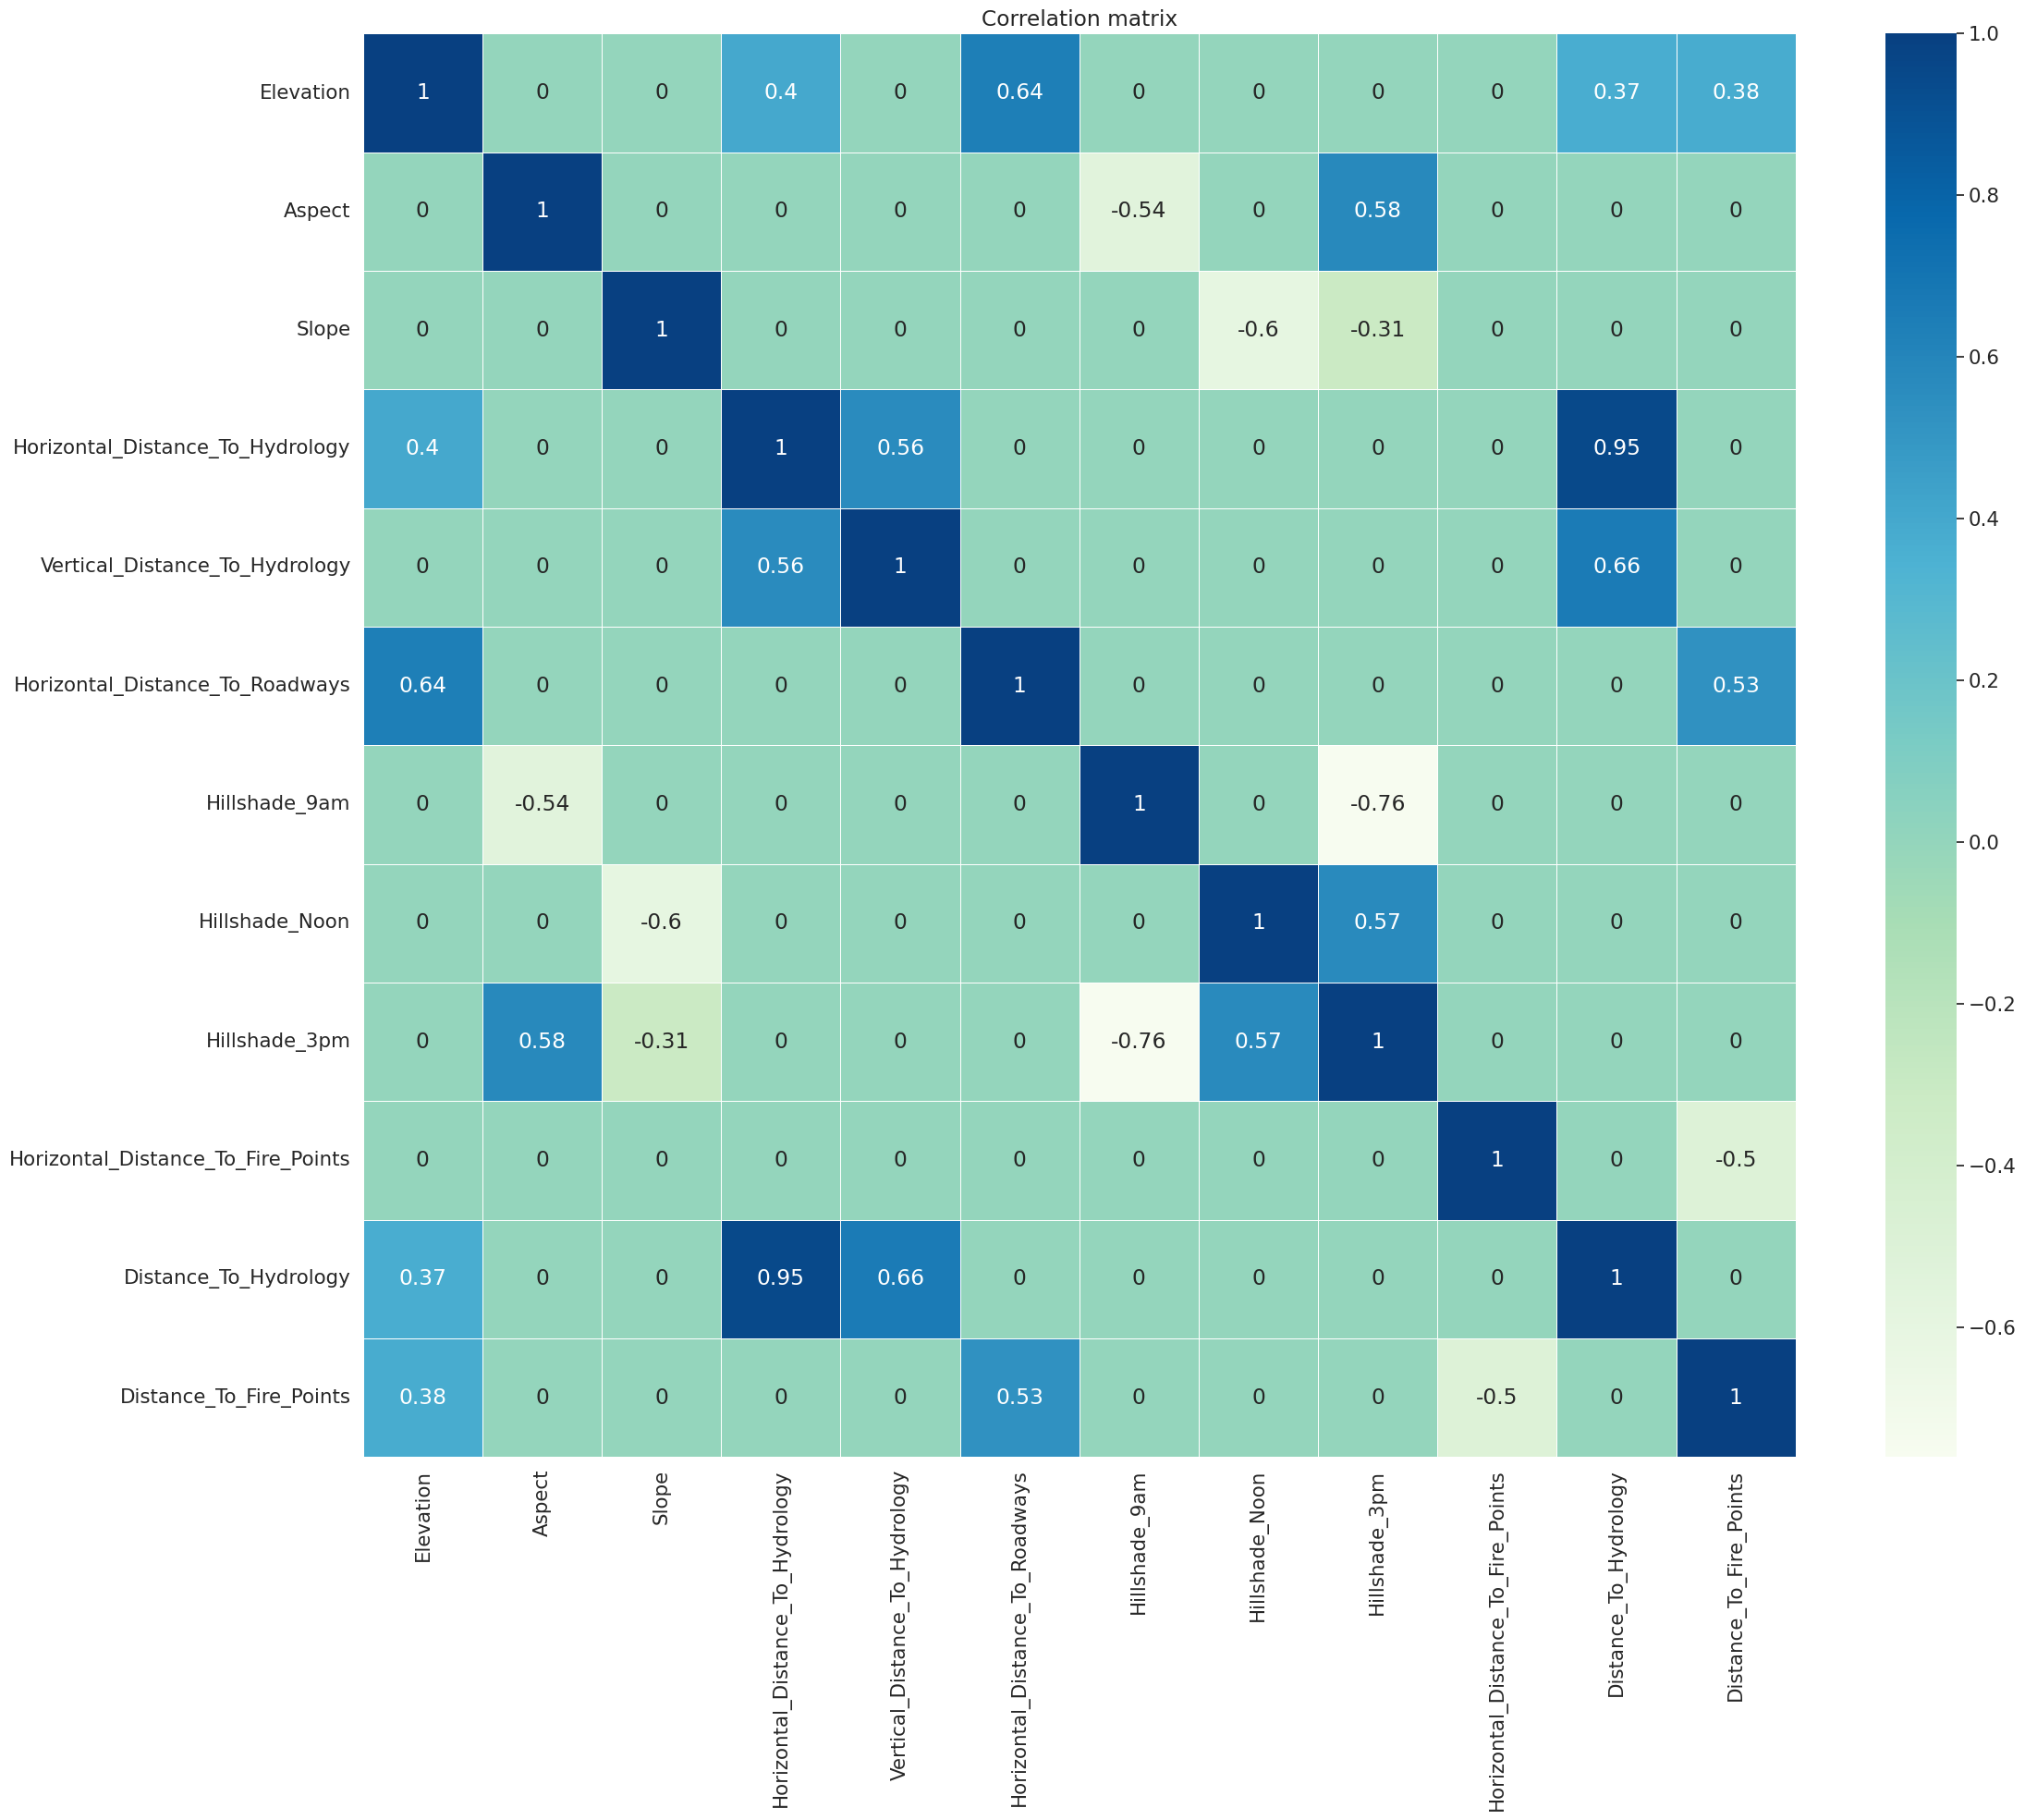

In [23]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)

corr_matrix = df_train[BASE_FEATURE_NAMES].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Elevation
MannwhitneyuResult(statistic=9224634041.0, pvalue=0.0)


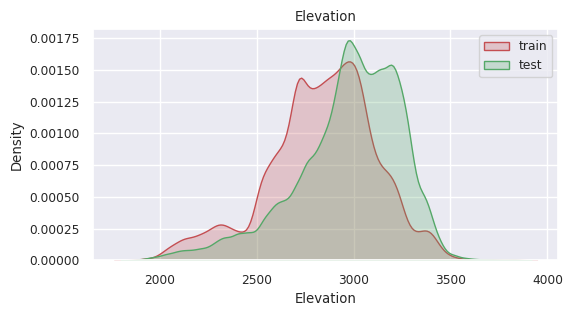

Aspect
MannwhitneyuResult(statistic=12370397381.0, pvalue=3.3419428776715143e-149)


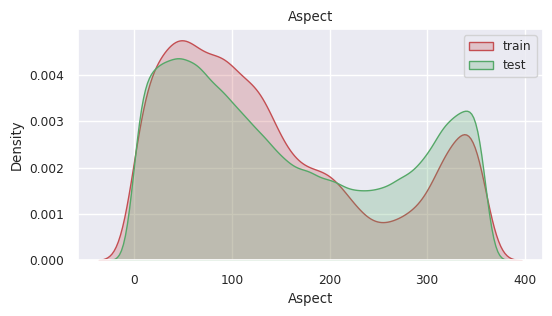

Slope
MannwhitneyuResult(statistic=12026416751.0, pvalue=4.4481992563319634e-278)


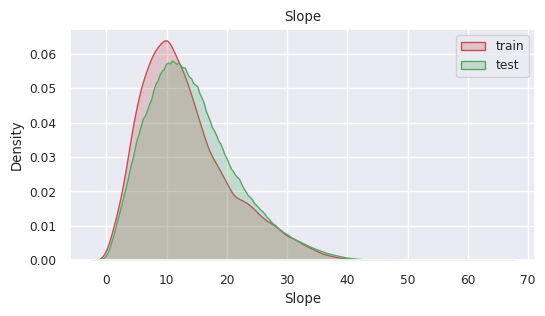

Horizontal_Distance_To_Hydrology
MannwhitneyuResult(statistic=12048841836.5, pvalue=4.212455942760784e-268)


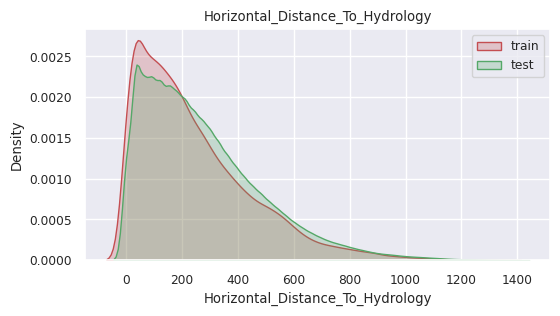

Vertical_Distance_To_Hydrology
MannwhitneyuResult(statistic=12516827955.5, pvalue=1.0967818217996323e-106)


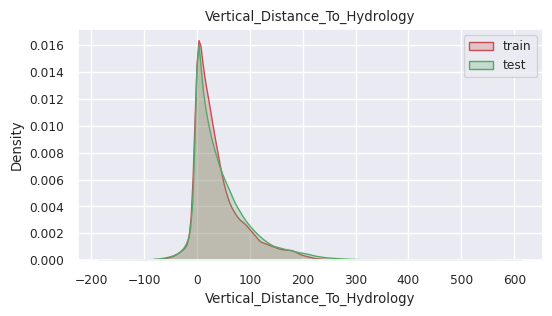

Horizontal_Distance_To_Roadways
MannwhitneyuResult(statistic=17097007806.0, pvalue=0.0)


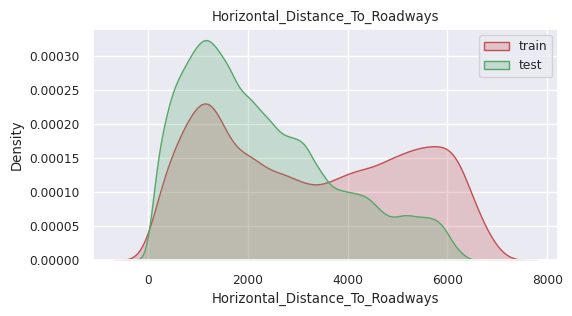

Hillshade_9am
MannwhitneyuResult(statistic=14706815619.0, pvalue=0.0)


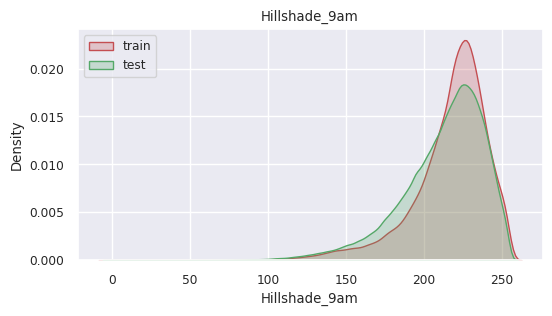

Hillshade_Noon
MannwhitneyuResult(statistic=13236645381.5, pvalue=0.059960104800882104)


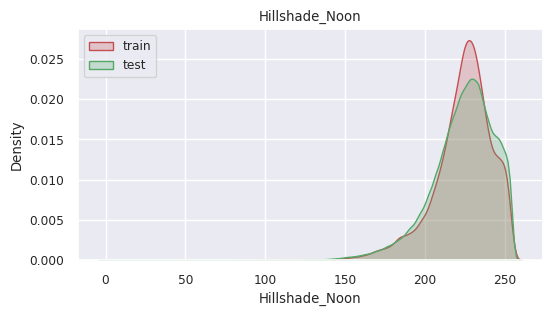

Hillshade_3pm
MannwhitneyuResult(statistic=12326270250.0, pvalue=1.8906825423433264e-163)


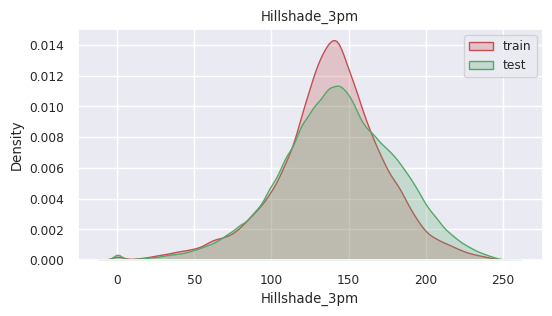

Horizontal_Distance_To_Fire_Points
MannwhitneyuResult(statistic=20075414067.5, pvalue=0.0)


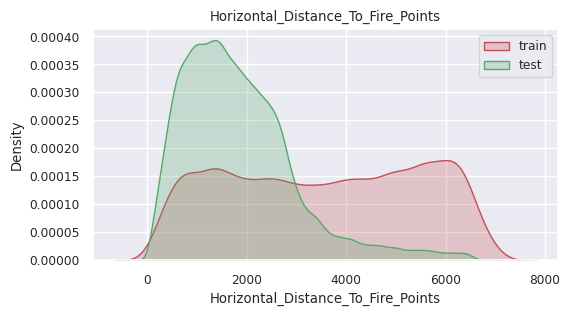

Distance_To_Hydrology
MannwhitneyuResult(statistic=nan, pvalue=nan)


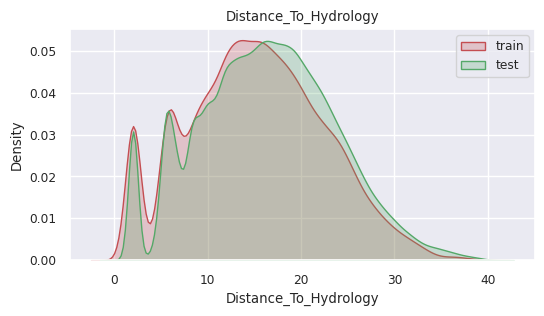

Distance_To_Fire_Points
MannwhitneyuResult(statistic=25220691006.0, pvalue=0.0)


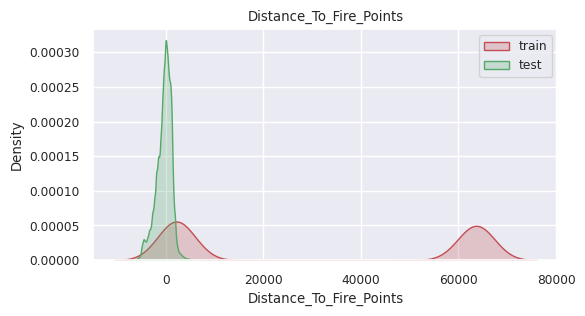

In [24]:
from scipy.stats import mannwhitneyu

figsize = (6, 3)
for col in BASE_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)

    sns.kdeplot(df_train[col], fill=True, label='train', color='r')
    sns.kdeplot(df_test[col], fill=True, label='test', color='g')
    
    print(col)
    print(mannwhitneyu(df_train[col], df_test[col]))
    
    plt.legend()
    plt.title(col)
    plt.show()

In [25]:
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.2,
                                                    random_state=21,
                                                    stratify=y)

## xgboost

In [26]:
y_train_transformed = y_train - 1
y_test_transformed = y_test - 1

In [27]:
# pipe_xgb = Pipeline([
#     ('scaler', StandardScaler()),
#     ('classifier', xgb.XGBClassifier(eval_metric='mlogloss'))
# ])

# param_grid_xgb = {
#     'classifier__n_estimators': [50, 100],
#     'classifier__max_depth': [3, 5],
#     'classifier__learning_rate': [0.01, 0.1],
#     'classifier__reg_lambda': [0.1, 1],
#     'classifier__reg_alpha': [0, 0.1]
# }

# grid_search_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search_xgb.fit(X_train, y_train_transformed)

# test_accuracy_xgb = grid_search_xgb.score(X_test, y_test_transformed)
# train_accuracy_xgb = grid_search_xgb.score(X_train, y_train_transformed)
# print("test_accuracy_xgb:", test_accuracy_xgb)
# print("train_accuracy_xgb:", train_accuracy_xgb)
# best_params = grid_search_xgb.best_params_
# print("Лучшие гиперпараметры для XGBoost:", best_params)

In [28]:
# best_xgb = xgb.XGBClassifier(
#     n_estimators=165,
#     max_depth=5,
#     learning_rate=0.1,
#     eval_metric='mlogloss'
# )

# best_xgb.fit(X_train, y_train_transformed)
# test_accuracy = best_xgb.score(X_test, y_test_transformed)
# train_accuracy = best_xgb.score(X_train, y_train_transformed)

# print("Точность на тестовом наборе:", test_accuracy)
# print("Точность на тренировочном наборе:", train_accuracy)

In [29]:
pipe_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', xgb.XGBClassifier(
        n_estimators=165,
        max_depth=5,
        learning_rate=0.1,
        eval_metric='mlogloss'
    ))
])

pipe_xgb.fit(X_train, y_train_transformed)

test_accuracy_xgb = pipe_xgb.score(X_test, y_test_transformed)
train_accuracy_xgb = pipe_xgb.score(X_train, y_train_transformed)

print("Точность на тестовом наборе:", test_accuracy_xgb)
print("Точность на тренировочном наборе:", train_accuracy_xgb)

Точность на тестовом наборе: 0.9177972865123704
Точность на тренировочном наборе: 0.9413407821229051


In [30]:
evaluate_preds(pipe_xgb, X_train, X_test, y_train_transformed, y_test_transformed)

TRAIN

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      8125
           1       0.96      0.97      0.96     23126
           2       0.88      0.84      0.86      1728
           3       0.97      0.99      0.98      1728
           4       0.88      0.95      0.92      1933
           5       0.84      0.91      0.88      1728
           6       0.96      0.99      0.98      1728

    accuracy                           0.94     40096
   macro avg       0.92      0.93      0.93     40096
weighted avg       0.94      0.94      0.94     40096

TEST

              precision    recall  f1-score   support

           0       0.91      0.83      0.87      2031
           1       0.94      0.96      0.95      5782
           2       0.78      0.75      0.76       432
           3       0.91      0.96      0.93       432
           4       0.86      0.91      0.89       483
           5       0.77      0.82      0.80       432
           

In [31]:
results_xgb = {
    'Model': 'XGBoost',
    'Test Accuracy': test_accuracy_xgb,
    'Train Accuracy': train_accuracy_xgb
}
results_xgb

{'Model': 'XGBoost',
 'Test Accuracy': 0.9177972865123704,
 'Train Accuracy': 0.9413407821229051}

## LGBMClassifier

In [32]:
# pipe_lgb = Pipeline([
#     ('scaler', StandardScaler()),
#     ('classifier', lgb.LGBMClassifier())
# ])

# param_grid_lgb = {
#     'classifier__n_estimators': [50, 100, 200],
#     'classifier__max_depth': [-1, 10, 20],
#     'classifier__learning_rate': [0.01, 0.1, 0.2]
# }

# grid_search_lgb = GridSearchCV(pipe_lgb, param_grid_lgb, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search_lgb.fit(X_train, y_train)

In [33]:
# print(grid_search_lgb.best_params_)
# print(grid_search_lgb.best_score_)
# test_accuracy_lgb = grid_search_lgb.score(X_test, y_test)
# train_accuracy_lgb = grid_search_lgb.score(X_train, y_train)
# print('Accuracy on LightGBM test:',test_accuracy_lgb)
# print('Accuracy on LightGBM train:',train_accuracy_lgb)

In [34]:
pipe_lgb = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', lgb.LGBMClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.2,
        min_child_samples=35,
    ))
])

pipe_lgb.fit(X_train, y_train)

test_accuracy_lgb = pipe_lgb.score(X_test, y_test)
train_accuracy_lgb = pipe_lgb.score(X_train, y_train)

print('Accuracy on LightGBM test:', test_accuracy_lgb)
print('Accuracy on LightGBM train:', train_accuracy_lgb)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2631
[LightGBM] [Info] Number of data points in the train set: 40096, number of used features: 45
[LightGBM] [Info] Start training from score -1.596331
[LightGBM] [Info] Start training from score -0.550319
[LightGBM] [Info] Start training from score -3.144312
[LightGBM] [Info] Start training from score -3.144312
[LightGBM] [Info] Start training from score -3.032203
[LightGBM] [Info] Start training from score -3.144312
[LightGBM] [Info] Start training from score -3.144312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

In [35]:
evaluate_preds(pipe_lgb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           1       0.96      0.94      0.95      8125
           2       0.98      0.98      0.98     23126
           3       0.98      0.96      0.97      1728
           4       1.00      1.00      1.00      1728
           5       0.96      0.99      0.97      1933
           6       0.96      0.99      0.97      1728
           7       0.99      1.00      1.00      1728

    accuracy                           0.98     40096
   macro avg       0.98      0.98      0.98     40096
weighted avg       0.98      0.98      0.98     40096

TEST

              precision    recall  f1-score   support

           1       0.92      0.87      0.89      2031
           2       0.96      0.97      0.96      5782
           3       0.83      0.79      0.81       432
           4       0.92      0.96      0.94       432
           5       0.90      0.92      0.91       483
           6       0.80      0.86      0.83       432
           

In [36]:
results_lgb = {
    'Model': 'LightGBM',
    'Test Accuracy': test_accuracy_lgb,
    'Train Accuracy': train_accuracy_lgb
}
results_lgb

{'Model': 'LightGBM',
 'Test Accuracy': 0.9312649640861931,
 'Train Accuracy': 0.975882881085395}

## RandomForestClassifier

In [37]:
# pipe_rf = Pipeline([
#     ('scaler', StandardScaler()),
#     ('classifier', RandomForestClassifier())
# ])

# param_grid_rf = {
#     'classifier__n_estimators': [50, 100, 200],
#     'classifier__max_depth': [None, 10, 20, 30],
#  'classifier__min_samples_split': [2, 5],
#     'classifier__min_samples_leaf': [1, 2]
# }

# grid_search_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search_rf.fit(X_train, y_train)

# print("Лучшие параметры:", grid_search_rf.best_params_)
# print("Лучший результат:", grid_search_rf.best_score_)

# test_accuracy_rf = grid_search_rf.score(X_test, y_test)
# train_accuracy_rf = grid_search_rf.score(X_train, y_train)

# print('Точность на тестовом наборе:', test_accuracy_rf)
# print('Точность на тренировочном наборе:', train_accuracy_rf)


In [38]:
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=70,  
        max_depth=14,
    ))
])

pipe_rf.fit(X_train, y_train)

test_accuracy_rf = pipe_rf.score(X_test, y_test)
train_accuracy_rf = pipe_rf.score(X_train, y_train)


print('Accuracy on RandomForestClassifier test:', test_accuracy_rf)
print('Accuracy on RandomForestClassifier train:', train_accuracy_rf)

Accuracy on RandomForestClassifier test: 0.9124102154828412
Accuracy on RandomForestClassifier train: 0.957127893056664


In [39]:
evaluate_preds(pipe_rf, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           1       0.97      0.87      0.92      8125
           2       0.95      0.99      0.97     23126
           3       0.97      0.93      0.95      1728
           4       0.98      0.99      0.98      1728
           5       0.93      0.91      0.92      1933
           6       0.93      0.97      0.95      1728
           7       0.99      1.00      0.99      1728

    accuracy                           0.96     40096
   macro avg       0.96      0.95      0.95     40096
weighted avg       0.96      0.96      0.96     40096

TEST

              precision    recall  f1-score   support

           1       0.92      0.80      0.85      2031
           2       0.93      0.97      0.95      5782
           3       0.81      0.78      0.79       432
           4       0.90      0.95      0.92       432
           5       0.87      0.85      0.86       483
           6       0.79      0.83      0.81       432
           

In [40]:
results_rf = {
    'Model': 'RandomForestClassifier',
    'Test Accuracy': test_accuracy_rf,
    'Train Accuracy': train_accuracy_rf
}
results_rf

{'Model': 'RandomForestClassifier',
 'Test Accuracy': 0.9124102154828412,
 'Train Accuracy': 0.957127893056664}

## KNeighborsClassifier

In [41]:
# pipe_knn = Pipeline([
#     ('scaler', StandardScaler()),
#     ('classifier', KNeighborsClassifier())
# ])

# param_grid_knn = {
#     'classifier__n_neighbors': [3, 5, 7, 9, 11],
#     'classifier__leaf_size': [10, 20, 30, 40, 50],
# }

# grid_search_knn = GridSearchCV(pipe_knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search_knn.fit(X_train, y_train)

# print("Лучшие параметры:", grid_search_knn.best_params_)
# print("Лучший балл:", grid_search_knn.best_score_)

# test_accuracy_knn = grid_search_knn.score(X_test, y_test)
# train_accuracy_knn = grid_search_knn.score(X_train, y_train)

# print('Точность на тестовом наборе:', test_accuracy_knn)
# print('Точность на тренировочном наборе:', train_accuracy_knn)

In [42]:
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier(
        n_neighbors=7,  
        leaf_size=10,
        metric='minkowski',
    ))
])

pipe_knn.fit(X_train, y_train)

test_accuracy_knn = pipe_knn.score(X_test, y_test)
train_accuracy_knn = pipe_knn.score(X_train, y_train)


print('Accuracy on RKNeighborsClassifier test:', test_accuracy_knn)
print('Accuracy on KNeighborsClassifier train:', train_accuracy_knn)

Accuracy on RKNeighborsClassifier test: 0.8911612130885874
Accuracy on KNeighborsClassifier train: 0.9183958499600958


In [43]:
evaluate_preds(pipe_knn, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           1       0.90      0.86      0.88      8125
           2       0.95      0.96      0.95     23126
           3       0.82      0.76      0.79      1728
           4       0.89      0.97      0.93      1728
           5       0.83      0.88      0.85      1933
           6       0.80      0.82      0.81      1728
           7       0.92      0.94      0.93      1728

    accuracy                           0.92     40096
   macro avg       0.87      0.88      0.88     40096
weighted avg       0.92      0.92      0.92     40096

TEST

              precision    recall  f1-score   support

           1       0.86      0.82      0.84      2031
           2       0.94      0.94      0.94      5782
           3       0.72      0.66      0.69       432
           4       0.86      0.94      0.89       432
           5       0.78      0.85      0.81       483
           6       0.71      0.73      0.72       432
           

In [44]:
results_knn = {
    'Model': 'KNeighborsClassifier',
    'Test Accuracy': test_accuracy_knn,
    'Train Accuracy': train_accuracy_knn
}
results_knn

{'Model': 'KNeighborsClassifier',
 'Test Accuracy': 0.8911612130885874,
 'Train Accuracy': 0.9183958499600958}

In [45]:
comparison_df = pd.DataFrame([results_xgb, results_lgb, results_rf, results_knn])
print(comparison_df)

                    Model  Test Accuracy  Train Accuracy
0                 XGBoost       0.917797        0.941341
1                LightGBM       0.931265        0.975883
2  RandomForestClassifier       0.912410        0.957128
3    KNeighborsClassifier       0.891161        0.918396


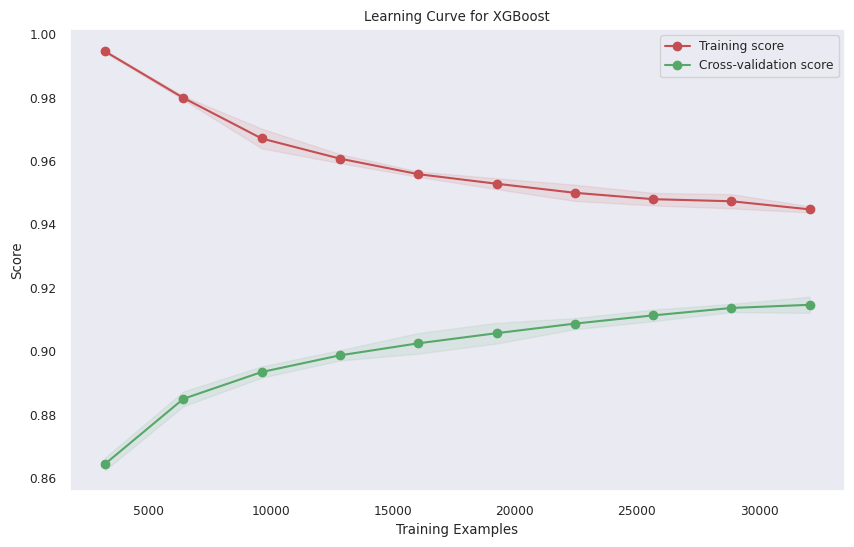

In [46]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    pipe_xgb, X_train, y_train_transformed, cv=5, scoring='accuracy', n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10)  
)


train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.grid()


plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")


plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curve for XGBoost")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()